In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
from numpy import random
import scipy

In [2]:
# 参数设置
mean1 = [0, 0]
cov1 = [[6, 0], [0, 6]]
mean2 = [1, 1]
cov2 = [[3, -1], [-1, 1]]
mean3 = [1, -1]
cov3 = [[1, 1], [1, 3]]

# 对协方差缩放
coe = 0.1
cov1 = np.dot(cov1, coe)
cov2 = np.dot(cov2, coe)
cov3 = np.dot(cov3, coe)

In [3]:
# 随机生成
x1, y1 = np.random.multivariate_normal(mean1, cov1, 100).T
point_x = []
point_y = []
for i in range(100):
    prob = random.random()
    if (prob >= 0.5):
        x, y = np.random.multivariate_normal(mean2, cov2, 1).T
    else:
        x, y = np.random.multivariate_normal(mean3, cov3, 1).T
    point_x.append(x[0])
    point_y.append(y[0])

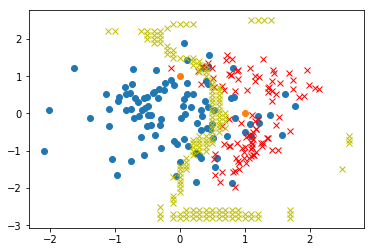

In [4]:
# 计算“区域”点，按行归档
boundary_x = []
boundary_y = []
margin = 1
factor = 10 # 散点间隔的细分程度
radius = 3 # 地图半径
threshold = 0.45 # 区域点的阈值
rows = {} # 键为y坐标，值为x的数组
for ii in range(-radius * factor, radius * factor, 1):
    for jj in range(-radius * factor, radius * factor, 1):
        count1 = 0
        count2 = 0
        i = ii / factor
        j = jj / factor
        points = rows.setdefault(j, [])
        for m in range(100):
            if ((x1[m] <= i + margin and x1[m] >= i - margin) and (y1[m] <= j + margin and y1[m] >= j - margin)):
                count1 += 1
        for m in range(100):
            if ((point_x[m] <= i + margin and point_x[m] >= i - margin) and (point_y[m] <= j + margin and point_y[m] >= j - margin)):
                count2 += 1
        if count1 + count2 == 0:
            continue
        if (count1 / (count1+count2) > threshold and count2 / (count1+count2) > threshold):
            boundary_x.append(i)
            boundary_y.append(j)
            points.append(i)
plt.plot(x1, y1, 'o')
plt.plot(point_x, point_y, 'x', color='r')
plt.plot(boundary_x, boundary_y, 'x', color='y')
plt.plot([0,1], [1,0], 'o')
plt.show()

In [5]:
# 简单把间隔超过阈值的划分为不同区域，计算每个区域的中点作为最终连线的点
max_gap = 0.8
bpoints = {} # 键为y坐标
for (k, v) in rows.items():
    start = 0
    bpoints[k] = []
    for i in range(1, len(v) + 1):
        if i == len(v) or v[i] - v[i - 1] > max_gap:
            bpoints[k].append(np.mean(v[start:i]))
            start = i

In [6]:
# （按行）对连线点分组为若干个线段
max_gap_x = 0.8
max_gap_y = 0.2
lines = []
for jj in range(-radius * factor, radius * factor, 1):
    jj /= factor
    for x in bpoints[jj]:
        alines = [] # 符合条件的线段
        for line in lines:
            if abs(line[-1][0] - x) <= max_gap_x and abs(line[-1][1] - jj) <= max_gap_y:
                alines.append(line)
        if len(alines) > 1: # 处理多个符合条件的情况，取x间隔小的
            index = 0
            mingapx = 999
            for i in range(len(alines)):
                factor = abs(alines[i][-1][0] - x)
                if mingapx > factor:
                    mingapx = factor
                    index = i
            alines = [alines[index]]
        if len(alines) == 0:
            lines.append([(x, jj)])
        else:
            alines[0].append((x, jj))

In [7]:
# 暂且选出最长的线段
cline = []
maxlen = 0
for line in lines:
    length = len(line)
    if maxlen < length:
        maxlen = length
        cline = line

In [8]:
# 为线段在y方向上做垂直延长
for j in range(-radius * factor, radius * factor, 1):
    jj = j / factor
    found = False
    for x, y in cline:
        if y == jj:
            found = True
            break
    if found:
        for y in range(j - 1, -radius * factor - 1, -1):
            cline.insert(0, (x, y / factor))
        break
for j in range(radius * factor - 1, -radius * factor - 1, -1):
    jj = j / factor
    found = False
    for x, y in cline:
        if y == jj:
            found = True
            break
    if found:
        for y in range(j + 1, radius * factor, 1):
            cline.append((x, y / factor))
        break

In [9]:
# 暂且把y映射到x，拟合为多项式
x_list = []
y_list = []

for x, y in cline:
    x_list.append(x)
    y_list.append(y)

degree = 8 # 多项式次数
c = np.polyfit(y_list, x_list, degree) # 多项式系数
def y2x(y):
    s = 0
    for i in range(len(c)):
        s += y ** (degree - i) * c[i]
    return s

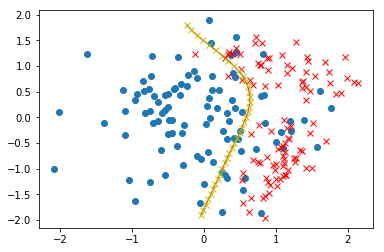

In [10]:
# 取坐标点y的极值作为边界，画出拟合线
x_list = []
y_list = []

min_y = min(np.append(y1, point_y))
max_y = max(np.append(y1, point_y))
for jj in range(-radius * factor, radius * factor, 1):
    jj /= factor
    if jj >= min_y and jj <= max_y:
        y_list.append(jj)
        x_list.append(y2x(jj))

# 画线：linewidth指定连线宽度，alpha指定连线的透明度
ax = plt.gca()
ax.plot(x_list, y_list, color='r', linewidth=1, alpha=1)

plt.plot(x1, y1, 'o')
plt.plot(point_x, point_y, 'x', color='r')
plt.plot(x_list, y_list, 'x', color='y')

plt.show()